# TODO

1. Gráficos para exploração de dados
 - tendência?
 - sazonalidade?
 - 
 
# Resources
- sarima lento a 365 dias - https://github.com/statsmodels/statsmodels/issues/5727

In [246]:
# standar lib
from itertools import product
import pickle
import time

# utils
import tqdm

# data & viz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset


# tsf
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import mean_absolute_error

#
from sklearn.metrics import mean_squared_error
from math import sqrt

# 1. Objetivos

Endereço do dataset:
https://www.kaggle.com/datasets/surajjha101/analyzing-and-prediction-of-bitcoin-pricing?resource=download

# 2. Data loading and preparation

In [49]:
fn = 'data/BTC-USD.csv'

In [50]:
df = pd.read_csv(fn, index_col='Date', parse_dates=True)
df.index.freq = 'D'

A frequência dos dados é diária.
Vamos dar essa indicação na estrutura de dados.

Os objetivos propostos para a análise são:
1. previsão da evolução do preço de fecho diário a 30 dias
2. previsão da evolução do preço médio semanal a 1 ano

# 3. Preço de "fecho"

Vamos começar por analisar o preço de "fecho" (criptomoedas não têm um momento de encerramento de transações, como outros instrumentos financeiros tradicionais, e.g. ações).

In [51]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [52]:
dfX = df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])
dfX = dfX.resample('W').mean()

lags = 12
period = 52
ma_window = 5

## 3.1. Exploração dos dados

<AxesSubplot:title={'center':'Weekly Close price'}, xlabel='Date'>

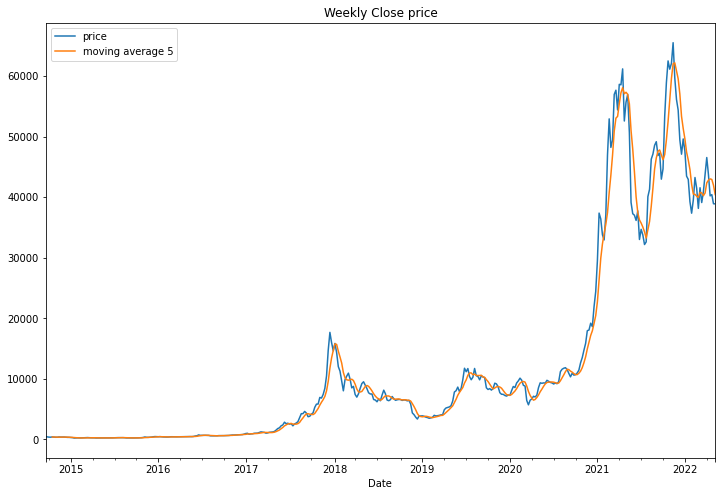

In [53]:
dfX.Close.plot(figsize=(12,8), title='Weekly Close price', label='price', legend=True)
dfX.Close.rolling(window=ma_window).mean().dropna().plot(label=f'moving average {ma_window}', legend=True)


/tmp/ipykernel_80626/1425490513.py:1: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dfX.Close.groupby(dfX.index.week).mean().plot(figsize=(12,8), title='Average weekly close per week of year')


<AxesSubplot:title={'center':'Average weekly close per week of year'}, xlabel='Date'>

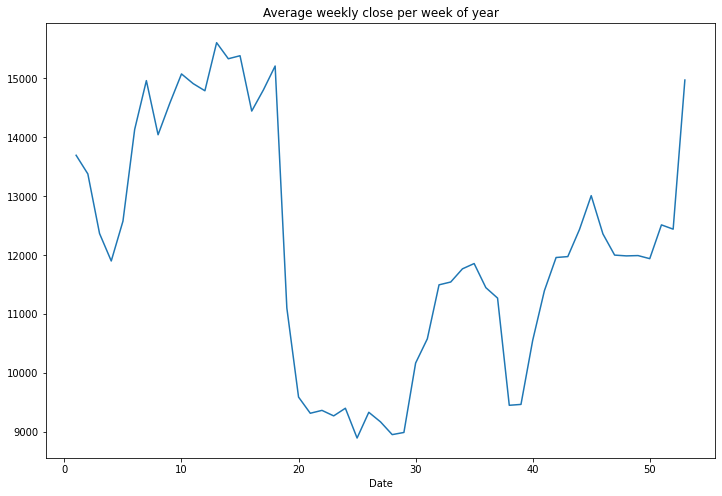

In [54]:
dfX.Close.groupby(dfX.index.week).mean().plot(figsize=(12,8), title='Average weekly close per week of year')


/tmp/ipykernel_80626/3197830046.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dfX_x.groupby(dfX_x.index.week).mean().plot(figsize=(12,8),


<AxesSubplot:title={'center':'Average weekly close per week of year before 2021'}, xlabel='Date'>

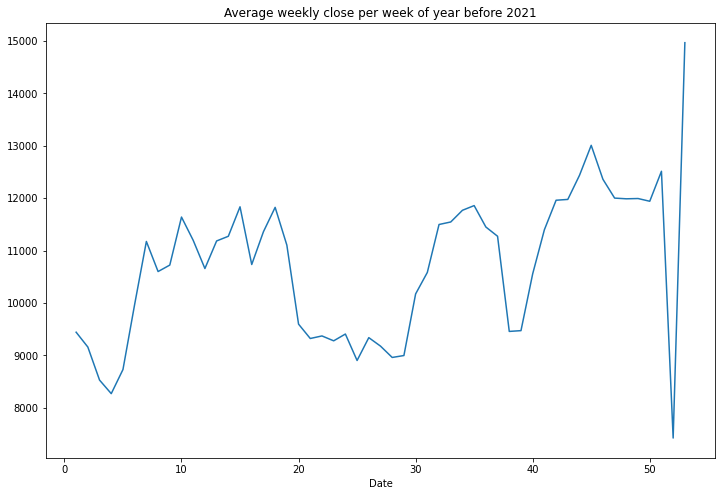

In [55]:
dfX_x = dfX.Close.loc[:'2021']
dfX_x.groupby(dfX_x.index.week).mean().plot(figsize=(12,8),
                                            title='Average weekly close per week of year before 2021')

/tmp/ipykernel_80626/3271671879.py:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  dfX_x.groupby(dfX_x.index.week).mean().plot(figsize=(12,8),


<AxesSubplot:title={'center':'Average weekly close per week of year after 2021'}, xlabel='Date'>

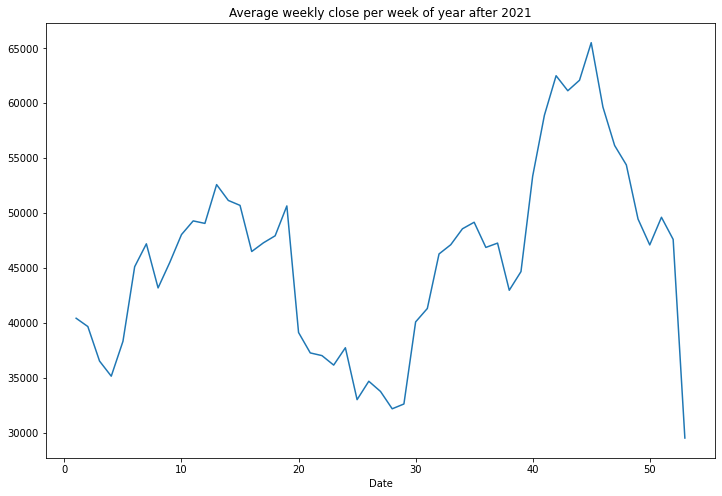

In [56]:
dfX_x = dfX.Close.loc['2021':]
dfX_x.groupby(dfX_x.index.week).mean().plot(figsize=(12,8),
                                            title='Average weekly close per week of year after 2021')

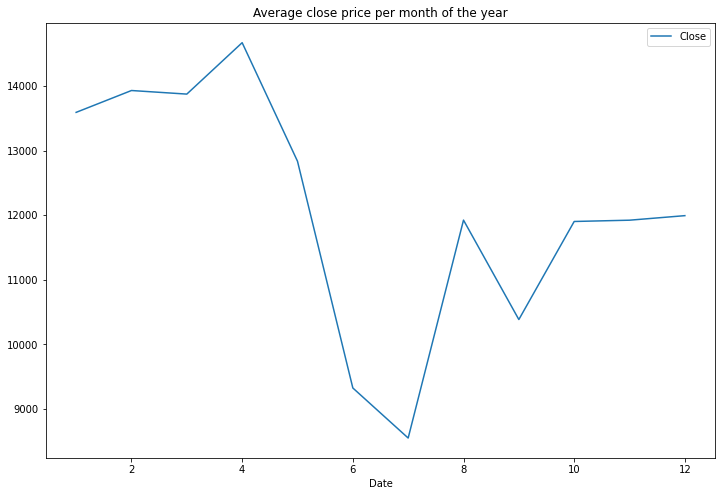

In [57]:
dfX.Close.groupby(dfX.Close.index.month).mean().plot(figsize=(12,8), title='Average close price per month of the year')
plt.legend()

## 3.2. Decompor série

Decomposição aditiva


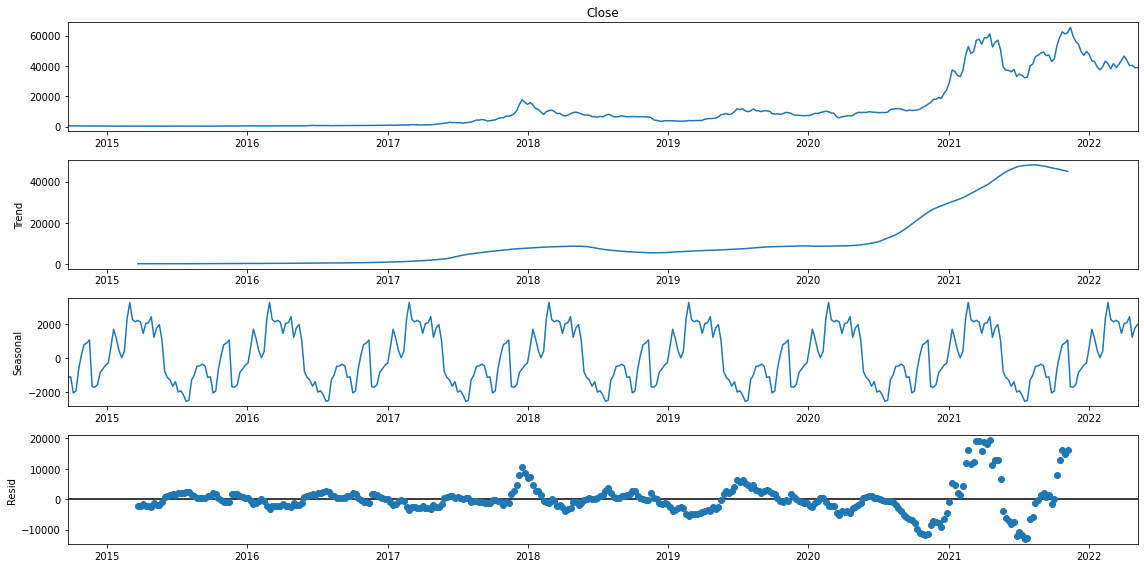

In [58]:
#Decomposition
decomposition = sm.tsa.seasonal_decompose(dfX.Close,
                                          model='additive',
                                          period=period)
plt.rcParams["figure.figsize"] = [16,8]
fig = decomposition.plot()
print('Decomposição aditiva')

In [233]:
plt.rcParams["figure.figsize"] = [16,8]


Decomposição multiplicativa


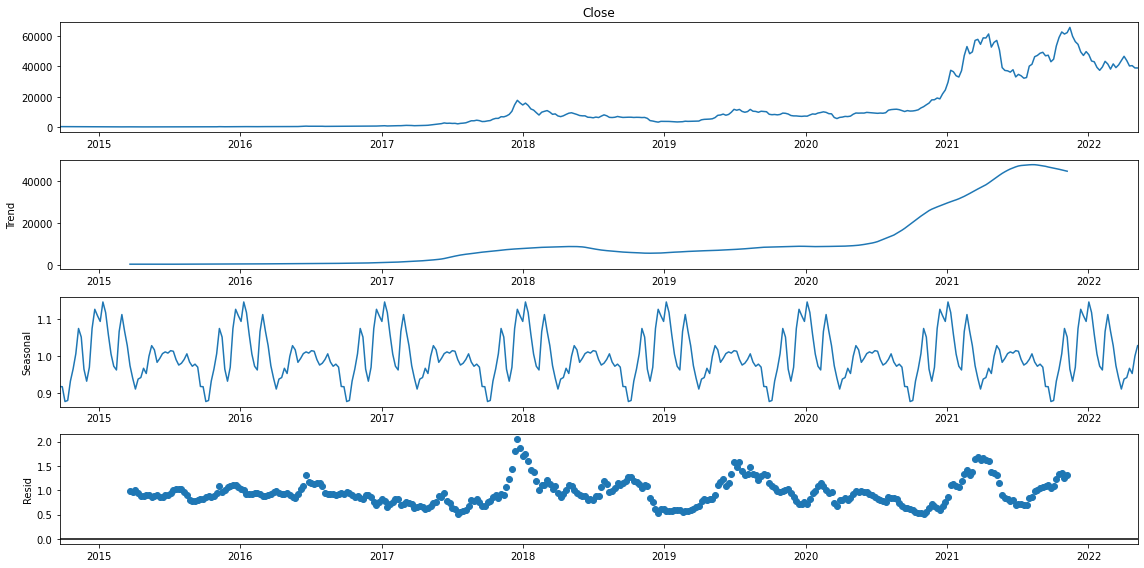

In [59]:
#Decomposition
decomposition = sm.tsa.seasonal_decompose(dfX.Close,
                                          model='multiplicative',
                                          period=period)
plt.rcParams["figure.figsize"] = [16,8]
decomposition.plot()
print('Decomposição multiplicativa')

## 3.3. ACF, PACF e estacionariedade

In [60]:
# Unit root tests
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
        

        
def stationary_tests(x, comment=''):
    print('\t', comment, '\n')
    print(adf_test(x))
    print(kpss_test(x))
    
def visualize_ts(x: pd.DataFrame, prefix='', lags=30):
    # Plot data
    x.plot(figsize=(12,8), title= f'{prefix} Close price', fontsize=14)

    # Compute Sample ACF and Sample PACF
    fig0 = plt.figure(figsize=(12,8))
    ax1 = fig0.add_subplot(211)
    fig0 = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax1)
    ax2 = fig0.add_subplot(212)
    fig0 = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax2)
    
    adf_test(x)
    
    
def apply_one_difference(x):
    dfX_1st_diff = x - x.shift(1)  
    return dfX_1st_diff.dropna(inplace=False)

def apply_difference(x, p=1):
    ts_diff = x - x.shift(p)  
    return ts_diff.dropna(inplace=False)

def apply_differences(x, n_diff):
    y = x
    for i in range(n_diff):
        y = apply_one_difference(y)
        print(y.shape)
    return y

In [61]:
data_transformations = {
    'original': dfX.Close,
    'log': dfX.Close.map(np.log),
    'diff_1': apply_difference(dfX.Close, 1),
    'diff_1_log': apply_difference(dfX.Close.map(np.log), 1),
    'diff_saz': apply_difference(dfX.Close, period),
    'diff_saz_log': apply_difference(dfX.Close.map(np.log), period),
    'diff_saz_diff_1': apply_difference(apply_difference(dfX.Close, 1)),
    'diff_saz_diff_1_log': apply_difference(apply_difference(dfX.Close.map(np.log), 1), period)
}

### 3.3.1. Série original

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                  -0.848425
p-value                          0.804482
#Lags Used                      17.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


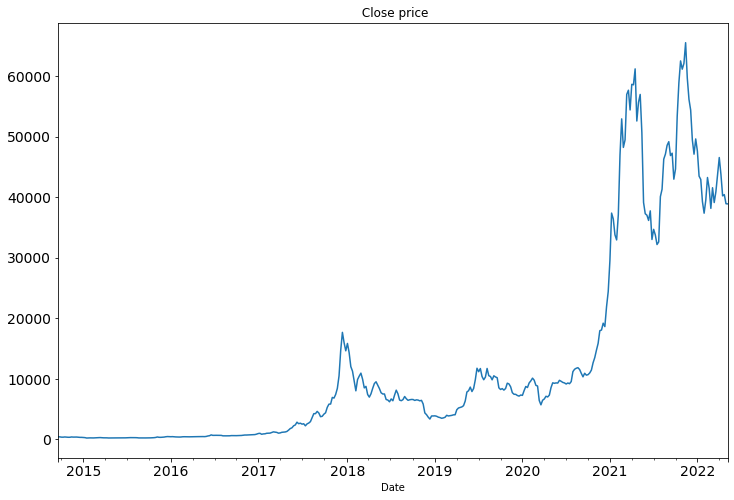

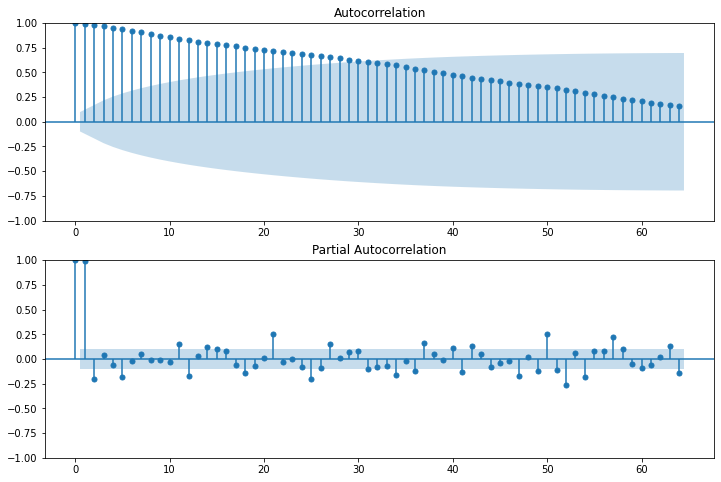

In [62]:
visualize_ts(data_transformations['original'], lags=period+lags)

### 3.3.2. Série Log

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                  -0.608325
p-value                          0.869090
#Lags Used                       1.000000
Number of Observations Used    397.000000
Critical Value (1%)             -3.446930
Critical Value (5%)             -2.868848
Critical Value (10%)            -2.570663
dtype: float64


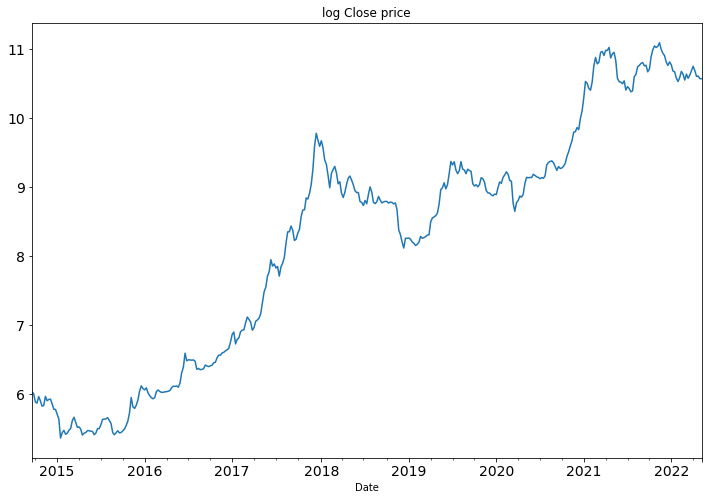

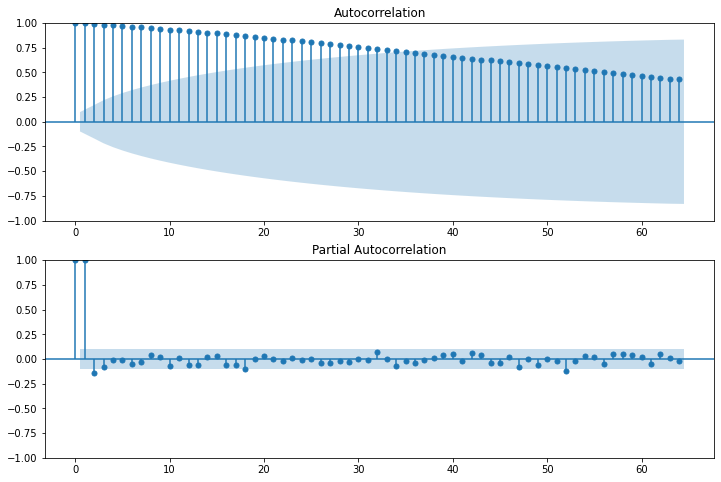

In [63]:
visualize_ts(data_transformations['log'], prefix='log', lags=period+lags)

### 3.3.3. Diferenças 1º grau

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                  -5.144676
p-value                          0.000011
#Lags Used                      16.000000
Number of Observations Used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


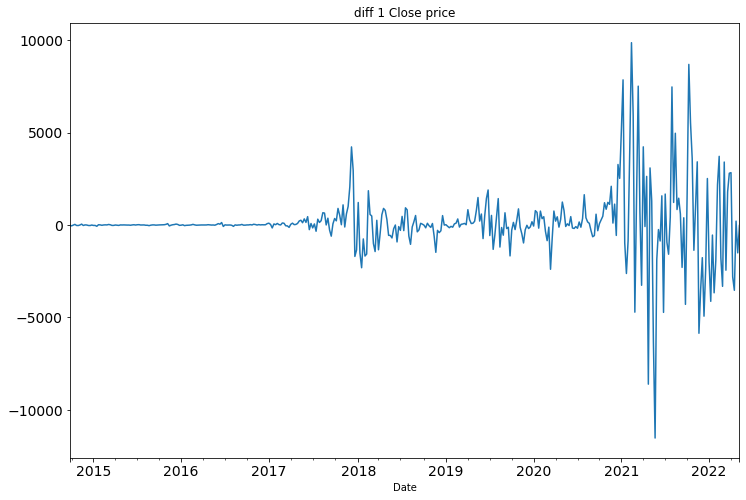

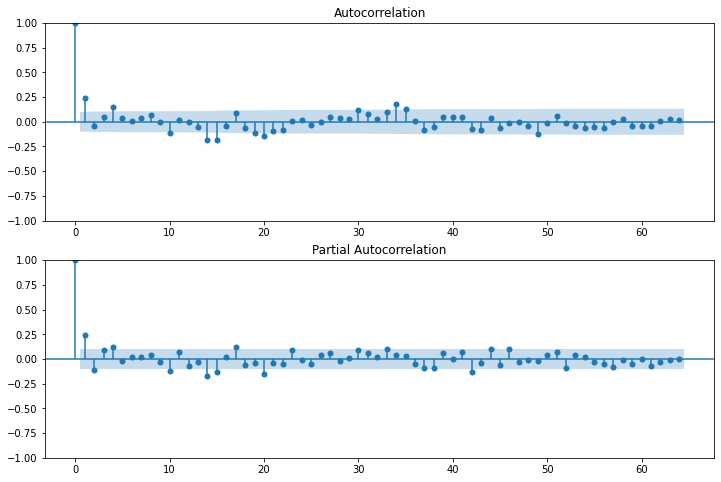

In [64]:
visualize_ts(apply_difference(dfX.Close, 1), prefix='diff 1', lags=period+lags)

### 3.3.4. Diferenças 1º grau Log

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                -1.478056e+01
p-value                        2.248928e-27
#Lags Used                     0.000000e+00
Number of Observations Used    3.970000e+02
Critical Value (1%)           -3.446930e+00
Critical Value (5%)           -2.868848e+00
Critical Value (10%)          -2.570663e+00
dtype: float64


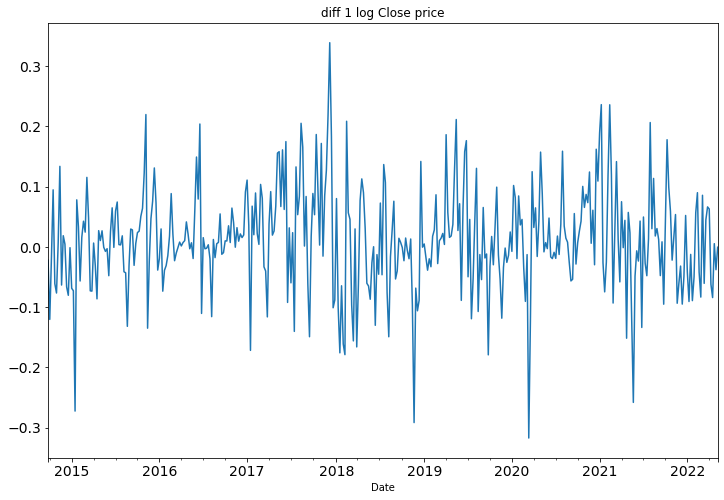

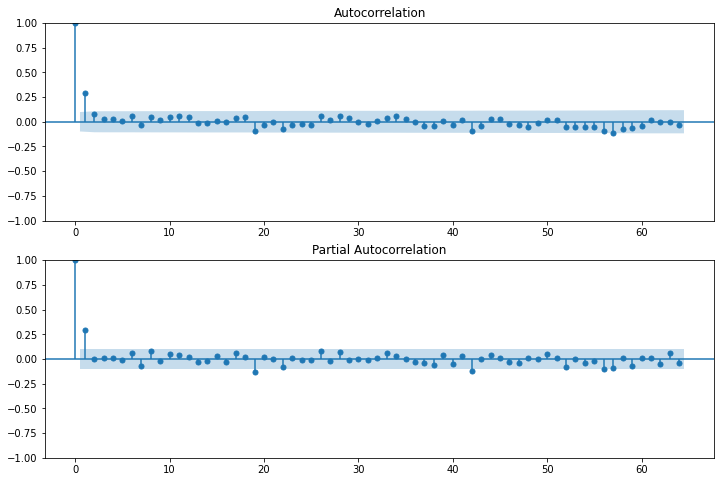

In [65]:
visualize_ts(apply_difference(dfX.Close.map(np.log), 1), prefix='diff 1 log', lags=period+lags)

### 3.3.5. Diferenças sazonais

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                  -2.473368
p-value                          0.122089
#Lags Used                       4.000000
Number of Observations Used    342.000000
Critical Value (1%)             -3.449616
Critical Value (5%)             -2.870028
Critical Value (10%)            -2.571292
dtype: float64


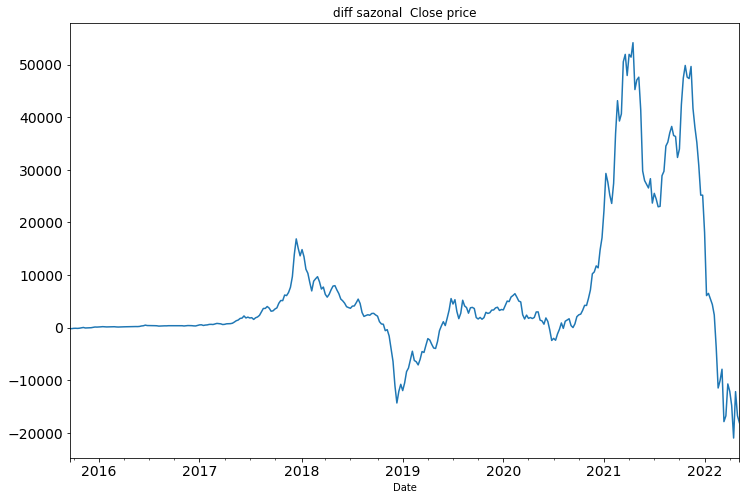

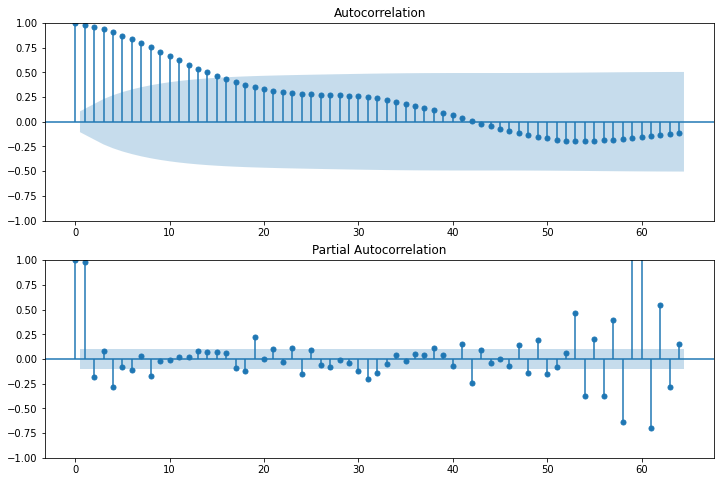

In [66]:
visualize_ts(apply_difference(dfX.Close, period), prefix='diff sazonal ', lags=period+lags)

### 3.3.6. Diferenças sazonais Log

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                  -1.924190
p-value                          0.320768
#Lags Used                       1.000000
Number of Observations Used    345.000000
Critical Value (1%)             -3.449447
Critical Value (5%)             -2.869954
Critical Value (10%)            -2.571253
dtype: float64


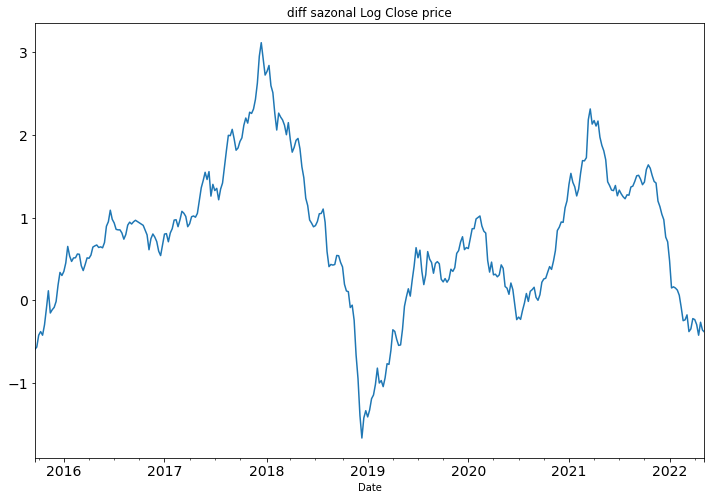

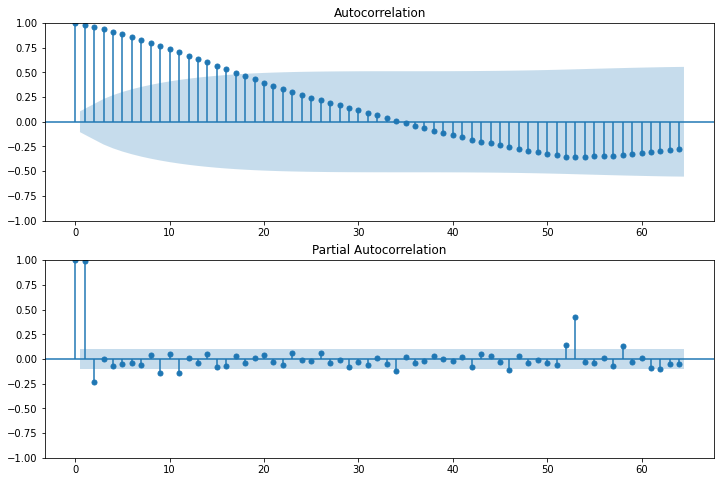

In [67]:
visualize_ts(apply_difference(dfX.Close.map(np.log), period), prefix=f'diff sazonal Log', lags=period+lags)

### 3.3.7 Diferenças sazonais 1º grau

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                -6.206356e+00
p-value                        5.645317e-08
#Lags Used                     3.000000e+00
Number of Observations Used    3.420000e+02
Critical Value (1%)           -3.449616e+00
Critical Value (5%)           -2.870028e+00
Critical Value (10%)          -2.571292e+00
dtype: float64


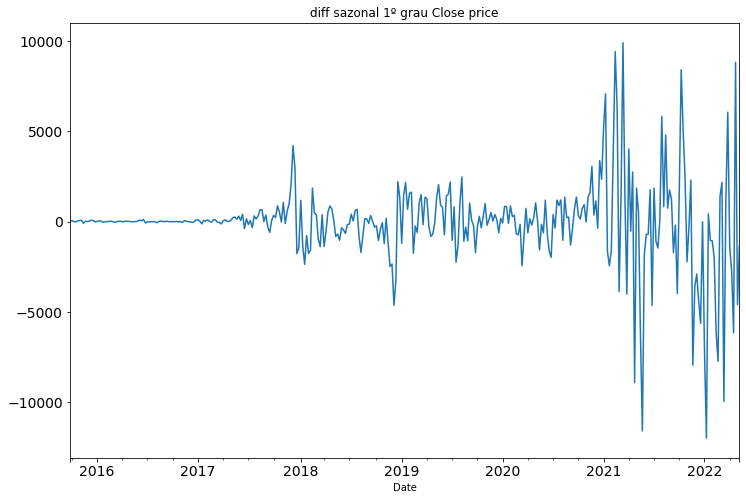

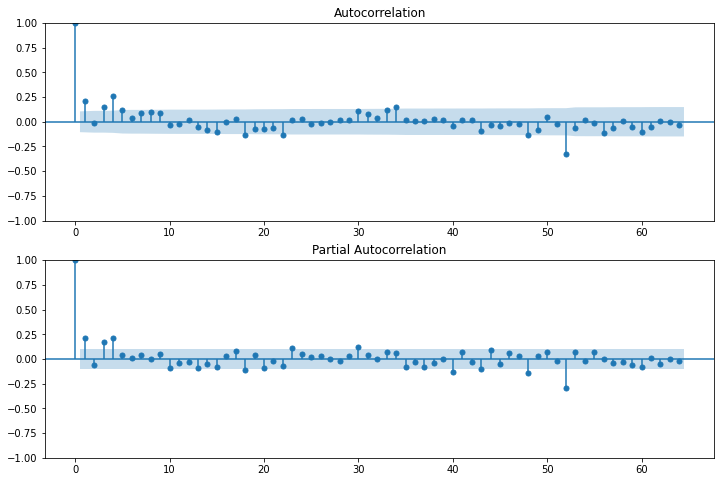

In [68]:
visualize_ts(apply_difference(apply_difference(dfX.Close, 1), period),
             prefix=f'diff sazonal 1º grau', lags=period+lags)

### 3.3.8. DIferenças sazonais 1º grau log

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                -1.363007e+01
p-value                        1.730089e-25
#Lags Used                     0.000000e+00
Number of Observations Used    3.450000e+02
Critical Value (1%)           -3.449447e+00
Critical Value (5%)           -2.869954e+00
Critical Value (10%)          -2.571253e+00
dtype: float64


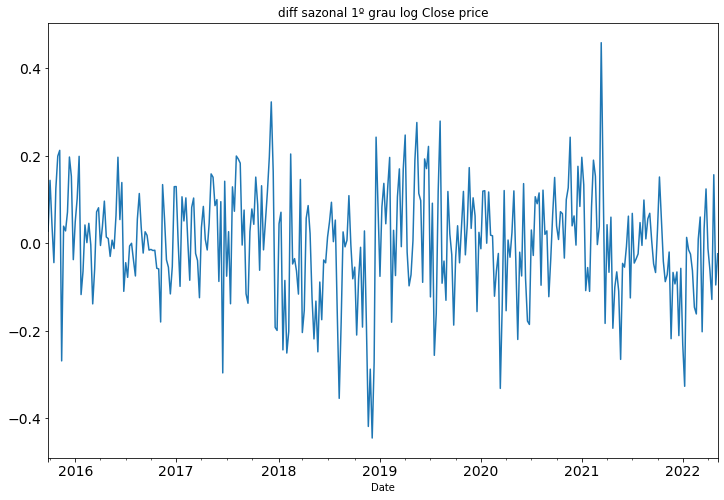

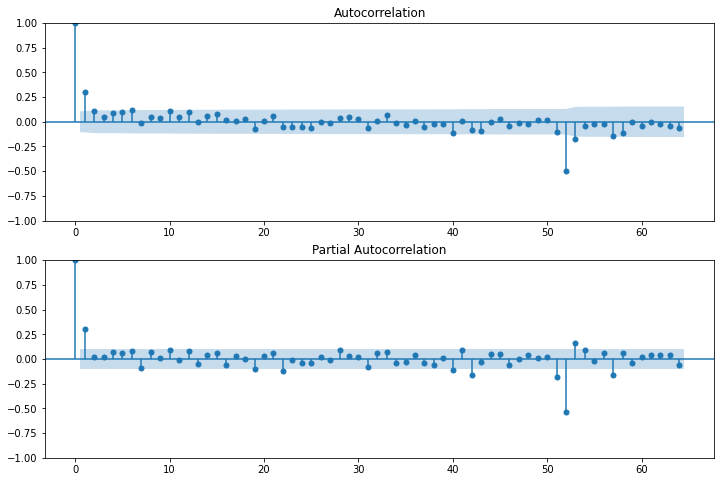

In [69]:
visualize_ts(apply_difference(apply_difference(dfX.Close.map(np.log), 1), period),
             prefix='diff sazonal 1º grau log', lags=period+lags)

# 4. Modelos

In [283]:
def get_metrics(true, pred):   
    # RMSE (HWA)
    rmse = round(np.sqrt(mean_squared_error(true, pred)),2)
    print("RMSE:",rmse)
    mae = round(mean_absolute_error(true,pred),2)
    print("MAE:",mae)
    mape = round(100*mean_absolute_percentage_error(true,pred),2)
    print("MAPE:",mape,'%')
    return rmse, mae, mape

## 4.1. Alisamento exponencial (12 week prediction)

In [262]:
dfE = dfX.copy()
dfE['Close'] = dfE['Close']

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


multiplicative model
RMSE: 4112.94
MAE: 3570.41
MAPE: 8.7 %
additive model
RMSE: 3345.78
MAE: 2994.26
MAPE: 7.44 %


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


(3345.78, 2994.26, 7.44)

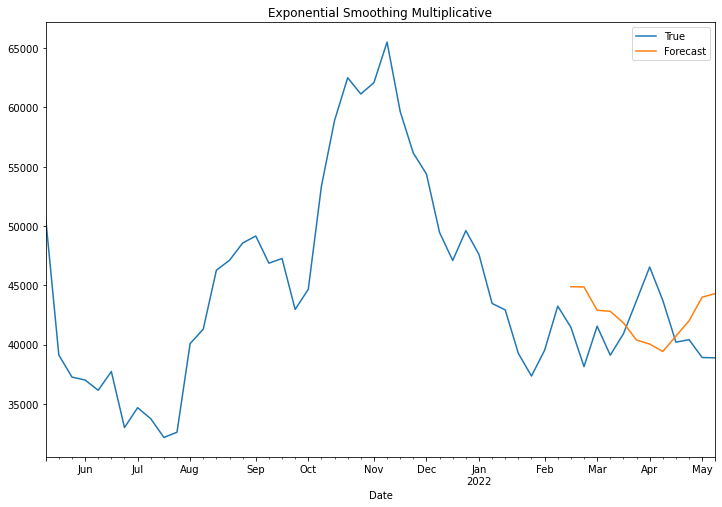

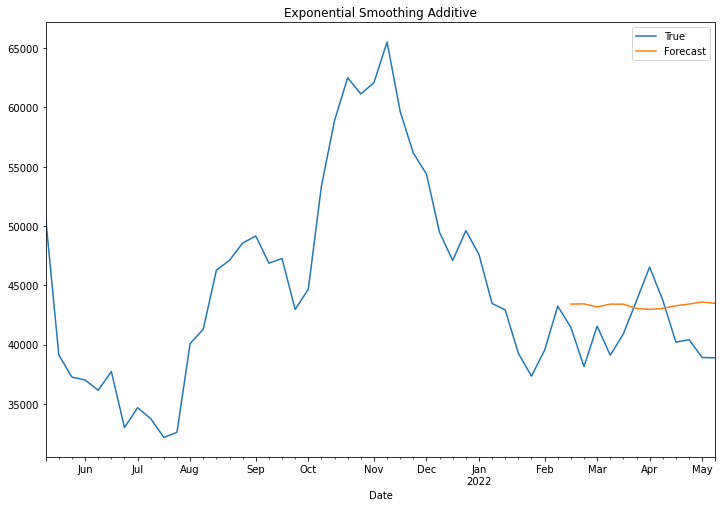

In [285]:
#Train and Test data Splitting 80- 20 
train_data = dfE.iloc[:-lags]
test_data = dfE.iloc[-lags:]

# Holt Winters multiplicative method
hwa_model = ExponentialSmoothing(train_data['Close'],
                                 trend='add',
                                 seasonal='multiplicative',
                                 seasonal_periods=period).fit()
hwa_test_pred = hwa_model.forecast(lags).rename('HWA close Forecast')
#print(hwa_test_pred)

plt.figure()
# train_data['Close'].plot(legend=True,label='Train')
# test_data['Close'].plot(legend=True,label='Test',figsize=(12,8))
dfE['Close'].iloc[-period:].plot(legend=True,label='True',figsize=(12,8))
hwa_test_pred.plot(legend=True,label='Forecast', title="Exponential Smoothing Multiplicative")

# RMSE (HWA)
print("multiplicative model")
get_metrics(test_data['Close'], hwa_test_pred)
# Holt Winters additive method

hwa_model = ExponentialSmoothing(train_data['Close'],
                                 trend='add',
                                 seasonal='additive',
                                 seasonal_periods=period).fit()
hwa_test_pred = hwa_model.forecast(lags).rename('HWA close_avg Forecast')
#print(hwa_test_pred)

plt.figure()
# train_data['Close'].plot(legend=True,label='Train')
# test_data['Close'].plot(legend=True,label='Test',figsize=(12,8))
dfE['Close'].iloc[-period:].plot(legend=True,label='True',figsize=(12,8))
hwa_test_pred.plot(legend=True,label='Forecast', title="Exponential Smoothing Additive")

# RMSE (HWA)
print("additive model")
get_metrics(test_data['Close'], hwa_test_pred)

## 4.1. Prepare grid search for ARIMA and ARIMAX

In [93]:
data_labels = list(data_transformations.keys())
# non seasonality
p = range(0,20,1) # ver diferneças sazonais + 1º grau
d = 1 # série torna-se estacionária com diferenças = 1
q = range(0,20,1)

# seasonality
P = range(0,5,1)
D = 1
Q = range(0,10,1)

In [ ]:
data_labels = list(data_transformations.keys())
# non seasonality
p = range(0,20,1) # ver diferneças sazonais + 1º grau
d = 1 # série torna-se estacionária com diferenças = 1
q = range(0,20,1)

# seasonality
P = range(0,5,1)
D = 1
Q = range(0,10,1)

In [94]:
print("tamanho do espaço ARIMA")
print(len(list(product(p,q))))

tamanho do espaço ARIMA
400


In [95]:
print("tamanho do espaço SARIMA")
print(len(list(product(p,q,P,Q))))

tamanho do espaço SARIMA
20000


In [167]:
1

1

## 4.2. ARIMA

### Grid search code

In [96]:
def optimize_ARIMA(ts, parameters_list, d, filename=None):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        ts - time series
        file - if present, write results to file in append mode
    """
    
    best_param = ()
    best_aic = None
    
    print('starting...')
    for i, param in enumerate(parameters_list):
        p, q = param
        print(i, param, 'best:', best_param, best_aic, )
        try:
            model = ARIMA(endog=ts,
                          order=(p, d, q))
            model_fit = model.fit()
        except e:
            print('got error at ', i, 'param:', param, 'd:', d, 'exception:', e)
            continue

        results = {}
        results['params'] = param
        results['aic'] = model_fit.aic
        
        
        if i == 0:
            best_aic = model_fit.aic
            best_param = param
            
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_param = param
            
        if filename is not None:
            pickle.dump(results, open(filename,"ab"))

### run grid search

In [98]:
optimize_ARIMA(dfX.Close, product(p,q), d, filename='arima_optimize.pkl')

starting...
0 (0, 0) best: () None
1 (0, 1) best: (0, 0) 7089.767176786021
2 (0, 2) best: (0, 1) 7062.486170212776
3 (0, 3) best: (0, 1) 7062.486170212776
4 (0, 4) best: (0, 1) 7062.486170212776
5 (0, 5) best: (0, 4) 7059.860876153056
6 (0, 6) best: (0, 4) 7059.860876153056
7 (0, 7) best: (0, 4) 7059.860876153056
8 (0, 8) best: (0, 4) 7059.860876153056
9 (0, 9) best: (0, 4) 7059.860876153056
10 (0, 10) best: (0, 4) 7059.860876153056
11 (0, 11) best: (0, 4) 7059.860876153056
12 (0, 12) best: (0, 11) 7056.66496200575
13 (0, 13) best: (0, 11) 7056.66496200575
14 (0, 14) best: (0, 11) 7056.66496200575
15 (0, 15) best: (0, 14) 7054.812353172676
16 (0, 16) best: (0, 15) 7051.946998545266
17 (0, 17) best: (0, 15) 7051.946998545266
18 (0, 18) best: (0, 17) 7046.691426781266
19 (0, 19) best: (0, 17) 7046.691426781266
20 (1, 0) best: (0, 17) 7046.691426781266
21 (1, 1) best: (0, 17) 7046.691426781266
22 (1, 2) best: (0, 17) 7046.691426781266
23 (1, 3) best: (0, 17) 7046.691426781266
24 (1, 4) be

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


34 (1, 14) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


35 (1, 15) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


36 (1, 16) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


37 (1, 17) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


38 (1, 18) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


39 (1, 19) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


40 (2, 0) best: (0, 17) 7046.691426781266
41 (2, 1) best: (0, 17) 7046.691426781266
42 (2, 2) best: (0, 17) 7046.691426781266
43 (2, 3) best: (0, 17) 7046.691426781266
44 (2, 4) best: (0, 17) 7046.691426781266
45 (2, 5) best: (0, 17) 7046.691426781266
46 (2, 6) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


47 (2, 7) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


48 (2, 8) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


49 (2, 9) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


50 (2, 10) best: (0, 17) 7046.691426781266
51 (2, 11) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


52 (2, 12) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


53 (2, 13) best: (0, 17) 7046.691426781266
54 (2, 14) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


55 (2, 15) best: (0, 17) 7046.691426781266
56 (2, 16) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


57 (2, 17) best: (0, 17) 7046.691426781266
58 (2, 18) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


59 (2, 19) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


60 (3, 0) best: (0, 17) 7046.691426781266
61 (3, 1) best: (0, 17) 7046.691426781266
62 (3, 2) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


63 (3, 3) best: (0, 17) 7046.691426781266
64 (3, 4) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


65 (3, 5) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


66 (3, 6) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


67 (3, 7) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


68 (3, 8) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


69 (3, 9) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


70 (3, 10) best: (0, 17) 7046.691426781266
71 (3, 11) best: (0, 17) 7046.691426781266
72 (3, 12) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


73 (3, 13) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


74 (3, 14) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


75 (3, 15) best: (0, 17) 7046.691426781266
76 (3, 16) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


77 (3, 17) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


78 (3, 18) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


79 (3, 19) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


80 (4, 0) best: (0, 17) 7046.691426781266
81 (4, 1) best: (0, 17) 7046.691426781266
82 (4, 2) best: (0, 17) 7046.691426781266
83 (4, 3) best: (0, 17) 7046.691426781266
84 (4, 4) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


85 (4, 5) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


86 (4, 6) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


87 (4, 7) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


88 (4, 8) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


89 (4, 9) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


90 (4, 10) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


91 (4, 11) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


92 (4, 12) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


93 (4, 13) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


94 (4, 14) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


95 (4, 15) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


96 (4, 16) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


97 (4, 17) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


98 (4, 18) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


99 (4, 19) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


100 (5, 0) best: (0, 17) 7046.691426781266
101 (5, 1) best: (0, 17) 7046.691426781266
102 (5, 2) best: (0, 17) 7046.691426781266
103 (5, 3) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


104 (5, 4) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


105 (5, 5) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


106 (5, 6) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


107 (5, 7) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


108 (5, 8) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


109 (5, 9) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


110 (5, 10) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


111 (5, 11) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


112 (5, 12) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


113 (5, 13) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


114 (5, 14) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


115 (5, 15) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


116 (5, 16) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


117 (5, 17) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


118 (5, 18) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


119 (5, 19) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


120 (6, 0) best: (0, 17) 7046.691426781266
121 (6, 1) best: (0, 17) 7046.691426781266
122 (6, 2) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


123 (6, 3) best: (0, 17) 7046.691426781266
124 (6, 4) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary 

125 (6, 5) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


126 (6, 6) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


127 (6, 7) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


128 (6, 8) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


129 (6, 9) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


130 (6, 10) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


131 (6, 11) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


132 (6, 12) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


133 (6, 13) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


134 (6, 14) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


135 (6, 15) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


136 (6, 16) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


137 (6, 17) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


138 (6, 18) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


139 (6, 19) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


140 (7, 0) best: (0, 17) 7046.691426781266
141 (7, 1) best: (0, 17) 7046.691426781266
142 (7, 2) best: (0, 17) 7046.691426781266
143 (7, 3) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary 

144 (7, 4) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


145 (7, 5) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


146 (7, 6) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


147 (7, 7) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


148 (7, 8) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


149 (7, 9) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


150 (7, 10) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


151 (7, 11) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


152 (7, 12) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


153 (7, 13) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


154 (7, 14) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


155 (7, 15) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


156 (7, 16) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


157 (7, 17) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


158 (7, 18) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


159 (7, 19) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


160 (8, 0) best: (0, 17) 7046.691426781266
161 (8, 1) best: (0, 17) 7046.691426781266
162 (8, 2) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


163 (8, 3) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


164 (8, 4) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


165 (8, 5) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


166 (8, 6) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


167 (8, 7) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


168 (8, 8) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


169 (8, 9) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


170 (8, 10) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


171 (8, 11) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


172 (8, 12) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


173 (8, 13) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


174 (8, 14) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


175 (8, 15) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


176 (8, 16) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


177 (8, 17) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


178 (8, 18) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


179 (8, 19) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


180 (9, 0) best: (0, 17) 7046.691426781266
181 (9, 1) best: (0, 17) 7046.691426781266
182 (9, 2) best: (0, 17) 7046.691426781266
183 (9, 3) best: (0, 17) 7046.691426781266
184 (9, 4) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary 

185 (9, 5) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


186 (9, 6) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


187 (9, 7) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


188 (9, 8) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


189 (9, 9) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


190 (9, 10) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


191 (9, 11) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


192 (9, 12) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


193 (9, 13) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


194 (9, 14) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


195 (9, 15) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


196 (9, 16) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


197 (9, 17) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


198 (9, 18) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


199 (9, 19) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


200 (10, 0) best: (0, 17) 7046.691426781266
201 (10, 1) best: (0, 17) 7046.691426781266
202 (10, 2) best: (0, 17) 7046.691426781266
203 (10, 3) best: (0, 17) 7046.691426781266
204 (10, 4) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary 

205 (10, 5) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


206 (10, 6) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


207 (10, 7) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


208 (10, 8) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


209 (10, 9) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


210 (10, 10) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


211 (10, 11) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


212 (10, 12) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


213 (10, 13) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


214 (10, 14) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


215 (10, 15) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


216 (10, 16) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


217 (10, 17) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


218 (10, 18) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


219 (10, 19) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


220 (11, 0) best: (0, 17) 7046.691426781266
221 (11, 1) best: (0, 17) 7046.691426781266
222 (11, 2) best: (0, 17) 7046.691426781266
223 (11, 3) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


224 (11, 4) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


225 (11, 5) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


226 (11, 6) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


227 (11, 7) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


228 (11, 8) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


229 (11, 9) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


230 (11, 10) best: (0, 17) 7046.691426781266


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


231 (11, 11) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


232 (11, 12) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


233 (11, 13) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


234 (11, 14) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


235 (11, 15) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


236 (11, 16) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


237 (11, 17) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


238 (11, 18) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


239 (11, 19) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


240 (12, 0) best: (11, 10) 7046.636612633991
241 (12, 1) best: (11, 10) 7046.636612633991
242 (12, 2) best: (11, 10) 7046.636612633991
243 (12, 3) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


244 (12, 4) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


245 (12, 5) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


246 (12, 6) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


247 (12, 7) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


248 (12, 8) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


249 (12, 9) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


250 (12, 10) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


251 (12, 11) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


252 (12, 12) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


253 (12, 13) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


254 (12, 14) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


255 (12, 15) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


256 (12, 16) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


257 (12, 17) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


258 (12, 18) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


259 (12, 19) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


260 (13, 0) best: (11, 10) 7046.636612633991
261 (13, 1) best: (11, 10) 7046.636612633991
262 (13, 2) best: (11, 10) 7046.636612633991
263 (13, 3) best: (11, 10) 7046.636612633991
264 (13, 4) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


265 (13, 5) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


266 (13, 6) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


267 (13, 7) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


268 (13, 8) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


269 (13, 9) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


270 (13, 10) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


271 (13, 11) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


272 (13, 12) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


273 (13, 13) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


274 (13, 14) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


275 (13, 15) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


276 (13, 16) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


277 (13, 17) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


278 (13, 18) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


279 (13, 19) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


280 (14, 0) best: (11, 10) 7046.636612633991
281 (14, 1) best: (11, 10) 7046.636612633991
282 (14, 2) best: (11, 10) 7046.636612633991


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


283 (14, 3) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


284 (14, 4) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


285 (14, 5) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


286 (14, 6) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


287 (14, 7) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


288 (14, 8) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


289 (14, 9) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


290 (14, 10) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


291 (14, 11) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


292 (14, 12) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


293 (14, 13) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


294 (14, 14) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


295 (14, 15) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


296 (14, 16) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


297 (14, 17) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


298 (14, 18) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


299 (14, 19) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


300 (15, 0) best: (14, 2) 7044.699901666065
301 (15, 1) best: (14, 2) 7044.699901666065
302 (15, 2) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


303 (15, 3) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


304 (15, 4) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


305 (15, 5) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


306 (15, 6) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


307 (15, 7) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


308 (15, 8) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


309 (15, 9) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


310 (15, 10) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


311 (15, 11) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


312 (15, 12) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


313 (15, 13) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


314 (15, 14) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


315 (15, 15) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


316 (15, 16) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


317 (15, 17) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


318 (15, 18) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


319 (15, 19) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


320 (16, 0) best: (14, 2) 7044.699901666065
321 (16, 1) best: (14, 2) 7044.699901666065
322 (16, 2) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


323 (16, 3) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


324 (16, 4) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


325 (16, 5) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


326 (16, 6) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


327 (16, 7) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


328 (16, 8) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


329 (16, 9) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


330 (16, 10) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


331 (16, 11) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


332 (16, 12) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


333 (16, 13) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


334 (16, 14) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


335 (16, 15) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


336 (16, 16) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


337 (16, 17) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


338 (16, 18) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


339 (16, 19) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


340 (17, 0) best: (14, 2) 7044.699901666065
341 (17, 1) best: (14, 2) 7044.699901666065
342 (17, 2) best: (14, 2) 7044.699901666065
343 (17, 3) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


344 (17, 4) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


345 (17, 5) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


346 (17, 6) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


347 (17, 7) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


348 (17, 8) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


349 (17, 9) best: (14, 2) 7044.699901666065


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


350 (17, 10) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


351 (17, 11) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


352 (17, 12) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


353 (17, 13) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


354 (17, 14) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


355 (17, 15) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


356 (17, 16) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


357 (17, 17) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


358 (17, 18) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


359 (17, 19) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


360 (18, 0) best: (17, 9) 7043.8870236214425
361 (18, 1) best: (17, 9) 7043.8870236214425
362 (18, 2) best: (17, 9) 7043.8870236214425
363 (18, 3) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


364 (18, 4) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


365 (18, 5) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


366 (18, 6) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


367 (18, 7) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


368 (18, 8) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


369 (18, 9) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


370 (18, 10) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


371 (18, 11) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


372 (18, 12) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


373 (18, 13) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


374 (18, 14) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


375 (18, 15) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


376 (18, 16) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


377 (18, 17) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


378 (18, 18) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


379 (18, 19) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


380 (19, 0) best: (17, 9) 7043.8870236214425
381 (19, 1) best: (17, 9) 7043.8870236214425
382 (19, 2) best: (17, 9) 7043.8870236214425
383 (19, 3) best: (17, 9) 7043.8870236214425
384 (19, 4) best: (17, 9) 7043.8870236214425
385 (19, 5) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


386 (19, 6) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


387 (19, 7) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


388 (19, 8) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


389 (19, 9) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


390 (19, 10) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


391 (19, 11) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


392 (19, 12) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


393 (19, 13) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


394 (19, 14) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


395 (19, 15) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


396 (19, 16) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


397 (19, 17) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


398 (19, 18) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


399 (19, 19) best: (17, 9) 7043.8870236214425


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Best

In [269]:
with open('arima_optimize.pkl', 'rb') as f:
    objs = []
    while True:
        try:
            o = pickle.load(f)
        except EOFError:
            break
        objs.append(o)

In [270]:
sorted(objs, key=lambda d: d['aic'])[:10]

[{'params': (17, 9), 'aic': 7043.8870236214425},
 {'params': (14, 2), 'aic': 7044.699901666065},
 {'params': (15, 6), 'aic': 7044.95350704379},
 {'params': (18, 9), 'aic': 7045.421152172172},
 {'params': (17, 7), 'aic': 7045.831805222506},
 {'params': (18, 12), 'aic': 7046.175899751672},
 {'params': (15, 7), 'aic': 7046.229739827551},
 {'params': (15, 2), 'aic': 7046.273422713946},
 {'params': (19, 12), 'aic': 7046.393599708347},
 {'params': (11, 10), 'aic': 7046.636612633991}]

In [277]:
%%time
model = ARIMA(endog=dfX.Close,
              order=(17, 1, 9))
model_fit = model.fit()

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


CPU times: user 43 s, sys: 45.5 s, total: 1min 28s
Wall time: 11.1 s


In [278]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  399
Model:                ARIMA(17, 1, 9)   Log Likelihood               -3494.944
Date:                Sun, 15 May 2022   AIC                           7043.887
Time:                        10:47:17   BIC                           7151.521
Sample:                    09-21-2014   HQIC                          7086.520
                         - 05-08-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1995      0.188     -1.058      0.290      -0.569       0.170
ar.L2          0.4042      0.125      3.245      0.001       0.160       0.648
ar.L3          0.1362      0.107      1.271      0.2

In [286]:
forecast = model_fit.predict(start = dfX.shape[0]-lags, end= dfX.shape[0]-1, dynamic= True)  

true, pred = dfX.Close.iloc[-lags:], forecast

get_metrics(true, pred)

RMSE: 6306.33
MAE: 4563.66
MAPE: 11.49 %


(6306.33, 4563.66, 11.49)

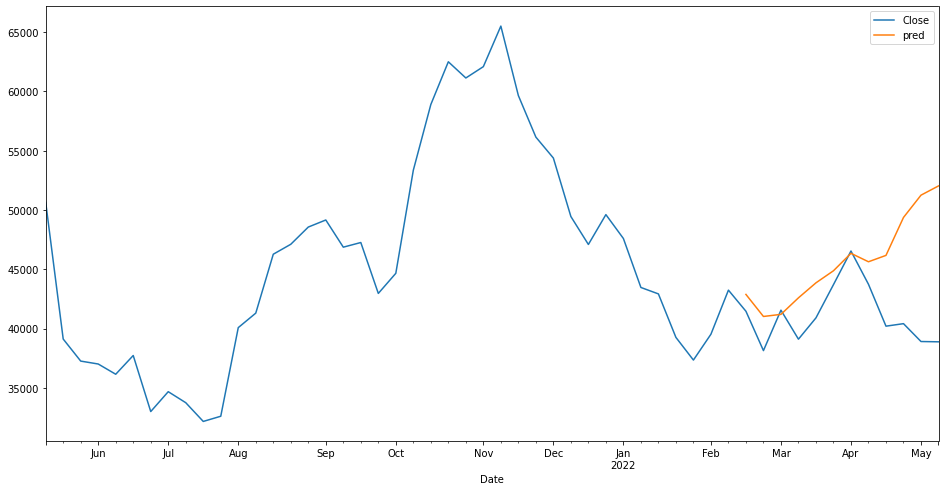

In [280]:
dfX.Close.iloc[-period:].plot()
forecast.plot(label='pred')
plt.legend()

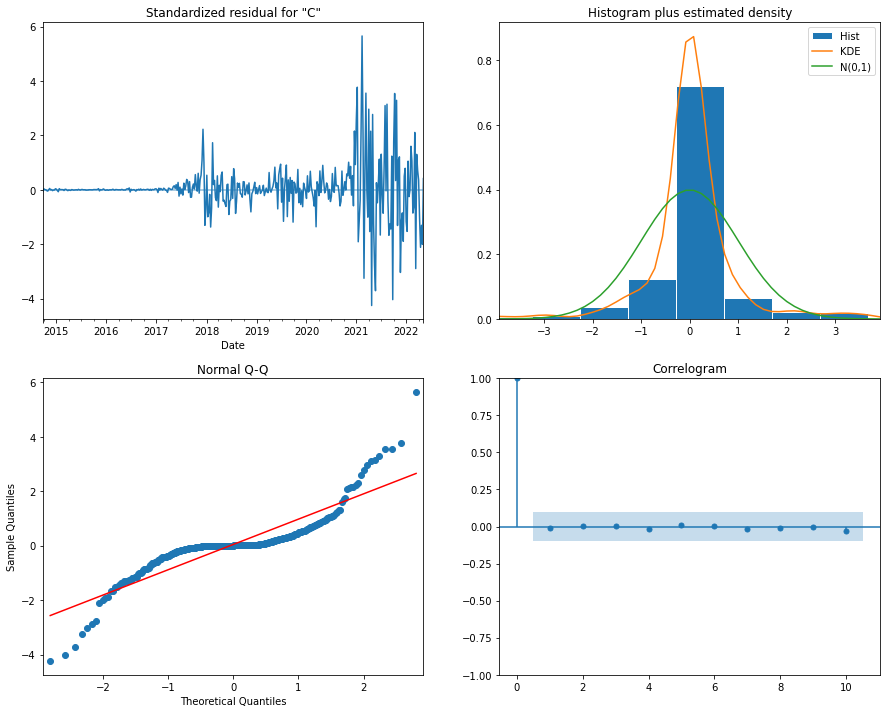

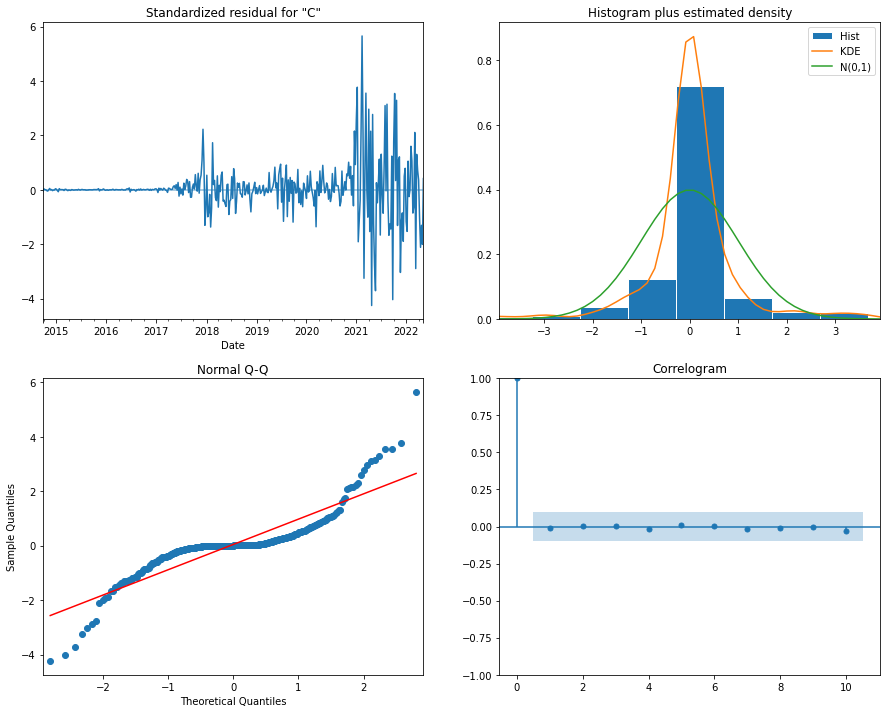

In [125]:
model_fit.plot_diagnostics(figsize=(15,12))

## 4.3. SARIMA

### grid search code

In [341]:
def sarima_single_run(ts, order, sorder, s, filename=None):
    p, d, q = order
    P, D, Q = sorder
    t_start = time.time()
        
    model = ARIMA(endog=dfX.Close,
                  order=(p, d, q),
                  seasonal_order=(P, D, Q, s)
                 )
    model_fit = model.fit()


    forecast = model_fit.predict(start = dfX.shape[0]-lags, end= dfX.shape[0]-1, dynamic= True)  

    true, pred = ts.iloc[-lags:], forecast
    # RMSE (HWA)
    rmse_arima = round(np.sqrt(mean_squared_error(true, pred)),2)
    mae_arima = round(mean_absolute_error(true,pred),2)
    mape_arima = round(100*mean_absolute_percentage_error(true,pred),2)

    fig_prediction = plt.figure()
    ts.iloc[-s:].plot()
    forecast.plot(label='pred')
    plt.legend()
    plt.savefig(f'sarima_{p}_{d}_{q}__{P}_{D}_{Q}_s52_prediction.svg')

    fig_diagnostics = plt.figure()
    model_fit.plot_diagnostics(figsize=(15,12))
    plt.savefig(f'sarima_{p}_{d}_{q}__{P}_{D}_{Q}_s52_diagnostics.svg')

    results = {}
    results['params'] = {'p':p, 'd':d, 'q':q, 'P': P, 'D':D, 'Q': Q, 's':s}
    results['summary'] = model_fit.summary()
    results['aic'] = model_fit.aic
    results['rmse'] = rmse_arima
    results['mae'] = mae_arima
    results['mape'] = mape_arima
    results['time'] = time.time() - t_start

    if filename is not None:
        pickle.dump(results, open(filename,"ab"))
    return results, model_fit

In [208]:
def optimize_SARIMA(ts, parameters_list, d, D, s, filename=None):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - season length
        file - if present, write results to file in append mode
    """
    
    best_param = ()
    best_aic = None
    
    print('starting...')
    for i, param in enumerate(parameters_list):
        # p, q = 3, 6
        p, q, P, Q = param
        # P, Q = param
        
        t_start = time.time()
        
        try:
            model = ARIMA(endog=dfX.Close,
                          order=(p, d, q),
                          seasonal_order=(P, D, Q, s)
                         )
            model_fit = model.fit()
        except Exception as e:
            print('got error at ', i, 'param:', param, 'd:', d, 'D:', D, 's:', s, 'exception:', e)
            continue

        forecast = model_fit.predict(start = dfX.shape[0]-lags, end= dfX.shape[0]-1, dynamic= True)  

        true, pred = data_transformations['log'].iloc[-lags:], forecast
        # RMSE (HWA)
        rmse_arima = round(np.sqrt(mean_squared_error(true, pred)),2)
        print("RMSE:",rmse_hwa)
        mae_arima = round(mean_absolute_error(true,pred),2)
        print("MAE:",mae_hwa)
        mape_arima = round(100*mean_absolute_percentage_error(true,pred),2)
        print("MAPE:",mape_hwa,'%')

        fig_prediction = plt.figure()
        dfX.Close.iloc[-period:].plot()
        forecast.plot(label='pred')
        plt.legend()
        plt.savefig(f'sarima_{p}_{d}_{q}__{P}_{D}_{Q}_s52_prediction.svg')

        fig_diagnostics = plt.figure()
        model_fit.plot_diagnostics(figsize=(15,12))
        plt.savefig(f'sarima_{p}_{d}_{q}__{P}_{D}_{Q}_s52_diagnostics.svg')

        results = {}
        results['params'] = {'p':p, 'd':d, 'q':q, 'P': P, 'D':D, 'Q': Q, 's':s}
        results['summary'] = model_fit.summary()
        results['aic'] = model_fit.aic
        results['rmse'] = rmse_arima
        results['mae'] = mae_arima
        results['mape'] = mape_arima
        results['time'] = time.time() - t_start
        
        if i == 0:
            best_aic = model_fit.aic
            best_param = param
            
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_param = param
            
        if filename is not None:
            pickle.dump(results, open(filename,"ab"))
            
        print(i, param, 'best:', best_param, best_aic, 'time', time.time() - t_start)

### run grid search

In [301]:
p_list = [0,1,2]  # ver ACF e PACF de diferenças de 1º grau
q_list = [0,1,2,3,4,5,6,7]
P_list = [0,1,2,3,4]  # ver ACF e PACF de diferenças sazonais c/ diferenças de 1º grau
Q_list = [0,1,2,3,4,5,6,7]

In [302]:
len(list(product(p_list, q_list, P_list, Q_list)))

960

In [ ]:
param_space = product(p_list, q_list, P_list, Q_list)
optimize_SARIMA(dfX.Close, param_space, d, D, period, filename='sarima_optimize.pkl')

### best

In [307]:
with open('sarima_optimize.pkl', 'rb') as f:
    objs = []
    while True:
        try:
            o = pickle.load(f)
        except EOFError:
            break
        objs.append(o)
top_sarima_aic = sorted(objs, key=lambda d: d['aic'])

{'params': {'p': 0, 'd': 1, 'q': 6, 'P': 1, 'D': 1, 'Q': 1, 's': 52},
 'summary': <class 'statsmodels.iolib.summary.Summary'>
 """
                                      SARIMAX Results                                      
 Dep. Variable:                              Close   No. Observations:                  399
 Model:             ARIMA(0, 1, 6)x(1, 1, [1], 52)   Log Likelihood               -3096.408
 Date:                            Sun, 15 May 2022   AIC                           6210.815
 Time:                                    11:02:43   BIC                           6245.433
 Sample:                                09-21-2014   HQIC                          6224.600
                                      - 05-08-2022                                         
 Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
 ----------------------------------------------------

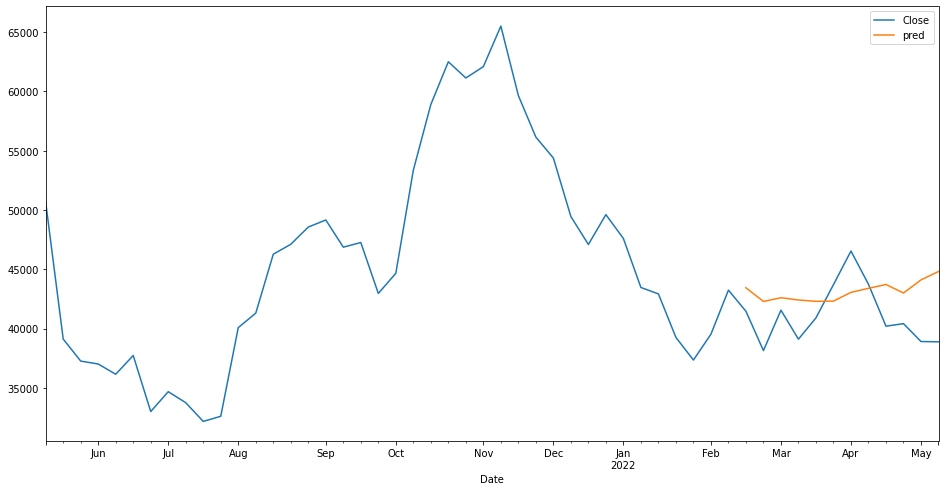

<Figure size 1152x576 with 0 Axes>

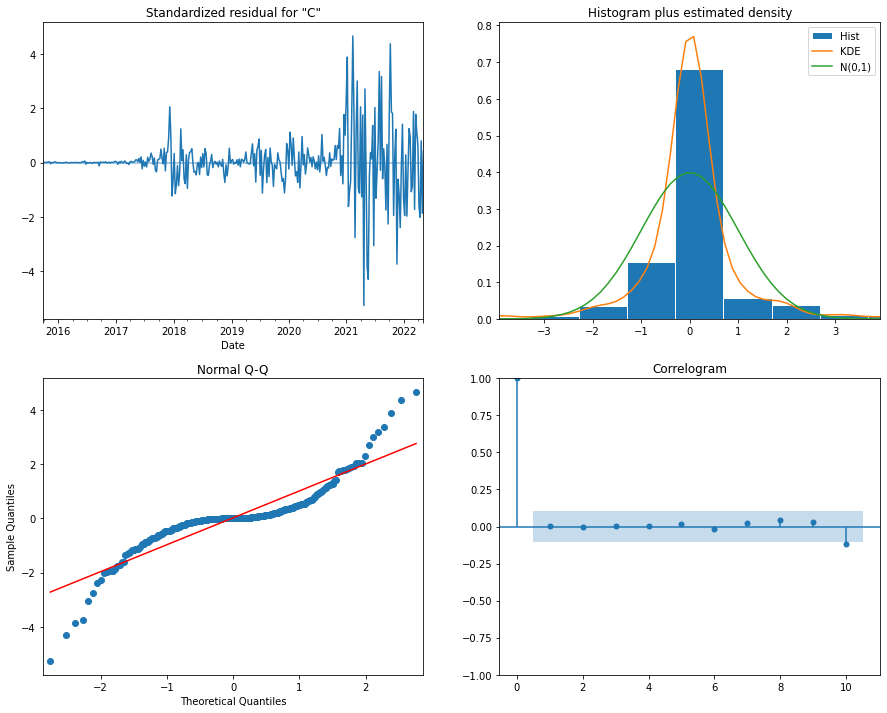

In [306]:
sarima_single_run(dfX.Close, (0, 1, 6), (1, 1, 1), 52, filename='sarima_optimize.pkl')

## 3.4. Prophet

In [287]:
import prophet

In [288]:
dfXX = pd.DataFrame()
dfXX['ds'] = dfX.index.values
dfXX['y'] = dfX.values

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version

Initial log joint probability = -11.9766
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       703.496     0.0110479       70.1283           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       703.707    0.00248192       167.367   2.701e-05       0.001      167  LS failed, Hessian reset 
     157       704.903   0.000107783       95.0013    1.22e-06       0.001      267  LS failed, Hessian reset 
     199       704.909   3.11892e-06       79.6467           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       705.123   1.29952e-05       63.1437      0.3408      0.3408      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     368       706.188     0.0050061        172.23   5.171e-05       0.001      590  LS failed, Hessian rese

CPU times: user 1.7 s, sys: 85 ms, total: 1.79 s
Wall time: 1.76 s


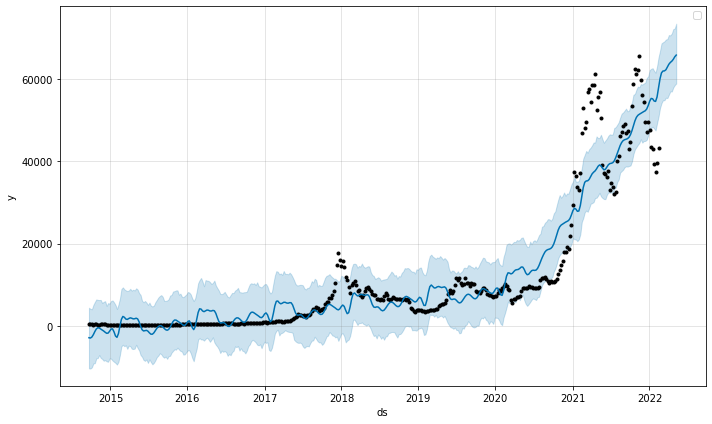

In [335]:
%%time
model = prophet.Prophet()
model.fit(dfXX.iloc[:-lags])

future = model.make_future_dataframe(periods=lags, freq='W')

forecast = model.predict(future)
model.plot(forecast)
plt.legend()

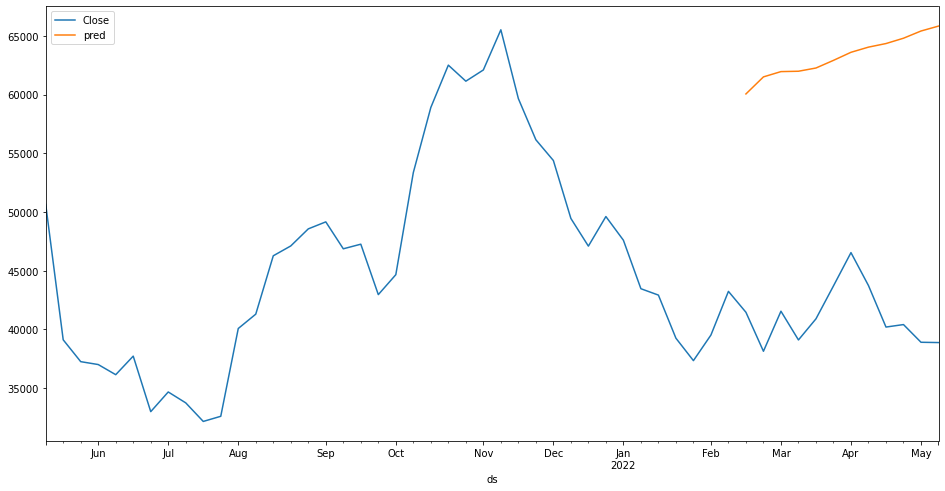

In [333]:
dfX.Close.iloc[-period:].plot()
forecast.set_index('ds').iloc[-lags:]['yhat'].plot(label='pred')
plt.legend()

In [337]:
dfXX['yhat'] = forecast['yhat']
dfXX

ds             y          yhat
0   2014-09-21    416.859003  -2852.846048
1   2014-09-28    407.692566  -2929.122108
2   2014-10-05    361.426570  -2678.895164
3   2014-10-12    355.234580  -2100.745708
4   2014-10-19    390.479854  -1356.288613
..         ...           ...           ...
394 2022-04-10  43738.103795  64033.864606
395 2022-04-17  40206.604911  64338.687362
396 2022-04-24  40418.150112  64792.292910
397 2022-05-01  38912.073103  65405.731769
398 2022-05-08  38886.741211  65825.156843

[399 rows x 3 columns]

In [338]:
true = dfXX['y'].iloc[-lags:]
pred = forecast['yhat'].iloc[-lags:]

get_metrics(true, pred)

RMSE: 22288.14
MAE: 22086.89
MAPE: 54.2 %


(22288.14, 22086.89, 54.2)

# 5. Melhor modelo, previsão futuro

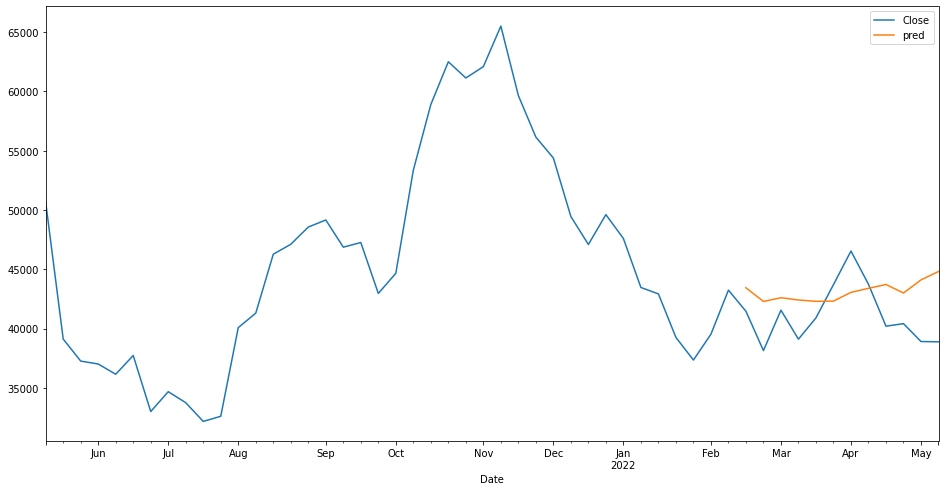

<Figure size 1152x576 with 0 Axes>

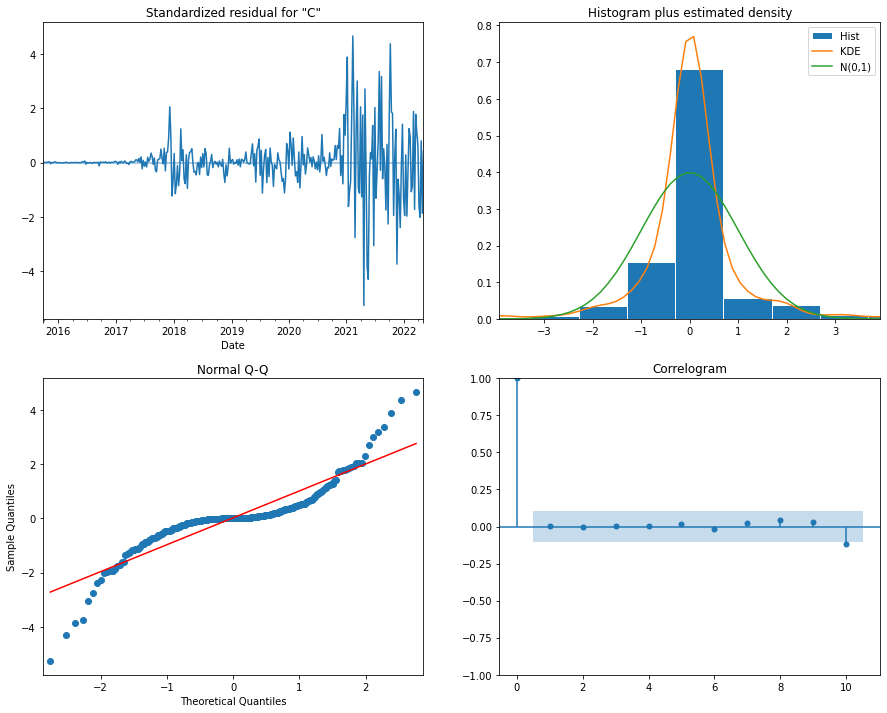

In [342]:
results, model_fit = sarima_single_run(dfX.Close, (0, 1, 6), (1, 1, 1), 52)

In [344]:
forecast = model_fit.predict(start = dfX.shape[0]-1, end= dfX.shape[0]+lags, dynamic= True)  

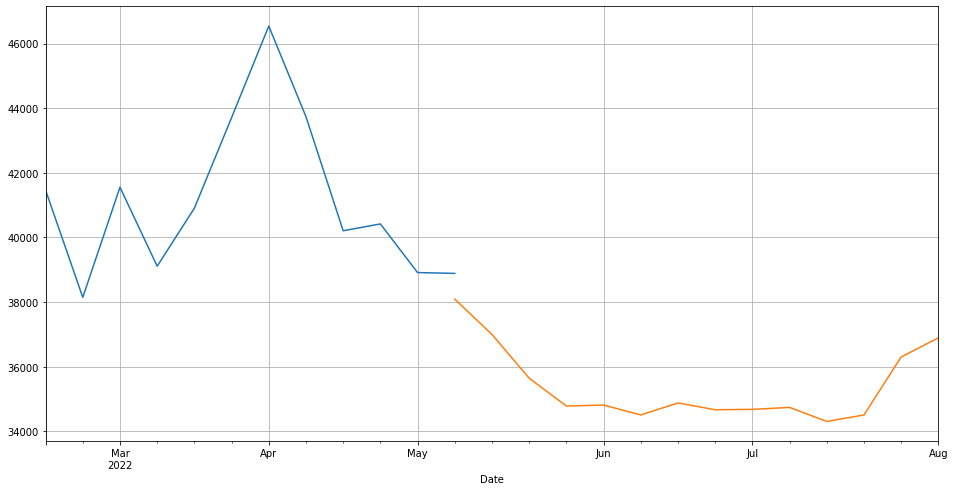

In [348]:
dfX.Close.iloc[-lags:].plot()
forecast.plot(label='pred')
plt.grid()